---
# VisionSpace Challenge
---
### Description
This notebook contains all the solutions and explanations for all three challenges.
### Requierements
The subsequent cell installs all packages that were utilized to solve the tasks.

In [ ]:
%pip install pandas
%pip install matplotlib
%pip install numpy
%pip install tensorflow 
%pip install scikit-learn

Now I import everything I need from these packages

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

from src.functions import *

**Assumption 1:** Given that the challenge is designed to take approximately four hours, it is essential to prioritize the most promising approaches and methods.

# Challenge I
---
## Desciption
The Janus satellite provides information that supports ground exploration missions on Mars. A sample
of the dataset in .csv format and a short description of its columns can be found in this repository:
https://github.com/visionspacetec/ai-interview-challanges.
Your goal is to apply Machine Learning techniques to predict Janus’ power consumption.
## Solution
**Assumption 2:** Since the exact prediction target is not specified, I set it to a next hour prediction, which also fits well with real-time monitoring needs and can be helpful in detecting anomalies. Another possibility would be to predict the next 24-hour profile, which would be useful for battery planning or solar panel orientation. I decided against this goal because the dataset is only about 20 days long and such a prediction would be very challenging because there may be long-term trends or periodic variations that are not captured by the data.

I start my solution by loading the raw data from the csv file.

In [14]:
# Define relative path to the dataset
current_dir_path = os.getcwd()
data_file_path = os.path.join(current_dir_path, 'SatelliteDataSet.csv')

# Load data to dataframe from csv file
df = pd.read_csv(data_file_path)

# All avialable features
all_features = ["power", "sa", "sx", "sy", "sz", "sunmars_km", 
                "earthmars_km", "sunmarsearthangle_deg", 
                "solarconstantmars", "eclipseduration_min", 
                "occultationduration_min", "flagcomms", 
                "ACROSS_TRACK", "D1PVMC", "D4PNPO", "EARTH", "INERTIAL",
                "MAINTENANCE", "NADIR", "RADIO_SCIENCE", "SLEW", "WARMUP"]

# The prediction target
target = "power"

## Data Engineering

In the next step, I want to identify the features that have the most influence on the power consumption of the satellite. I start by calculating the correlation between "power" and all other features.


In [3]:
# Compute correlation of power consumption with each feature
calc_corr_of_feature(df, all_features, target)

power corr: 0.38304193896251837
sa corr: 0.010232278603367171
sx corr: -0.020659383435740496
sy corr: 0.012383537069354298
sz corr: 0.014179640433799162
sunmars_km corr: 0.1962294165455303
earthmars_km corr: -0.20260707070038386
sunmarsearthangle_deg corr: 0.1976658647014179
solarconstantmars corr: -0.19570191037744972
eclipseduration_min corr: 0.08648581665241441
occultationduration_min corr: 0.19248589018312395
flagcomms corr: 0.00891526221939039
ACROSS_TRACK corr: 0.03296401766723174
D1PVMC corr: 0.10950823404970894
D4PNPO corr: nan
EARTH corr: -0.013219894917544169
INERTIAL corr: -0.027281450866336505
MAINTENANCE corr: -0.00844436666926823
NADIR corr: -0.04014718255718541
RADIO_SCIENCE corr: nan
SLEW corr: -0.020132352974782795
WARMUP corr: -0.019086343479864952


c:\Users\Diema2\Desktop\vs_challenge\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\Diema2\Desktop\vs_challenge\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


As expected, the current power consumption has the largest impact on the future power consumption. Other features such as the angle of the solar panels or the solar angle of the satellite have little effect on the power consumption, which makes sense. It also appears that some features from the spacecraft pointing events are always 0 and therefore have no value. Based on these considerations, I select the most promising features. This was a quick analysis for the scope of the challenge, there are many tools and methods to do more elaborate analyses.

In [15]:
features = ["power", 
            "sunmars_km",
            "earthmars_km", 
            "sunmarsearthangle_deg", 
            "solarconstantmars",  
            "occultationduration_min",
            #"ACROSS_TRACK", 
            #"NADIR",
            "D1PVMC", 
            #"EARTH",
            #"MAINTENANCE"
            ]

In a next step, it usually makes sense to derive additional features from the original features to improve the training stability and performance of the model. In the following I choose some promising examples. Since the past power consumption has a strong influence on the future power consumption, I decided to include the average power consumption of the last 3 and the last 5 hours as a feature. I also thought about adding the hour of the day to the feature since some tasks occur periodically, and I tried to increase the impact of the solar constant by combining it with the solar panel angle for an absolute solar power value.

In [16]:
# 3-hour mean and 5h mean
df['power_mean_3h'] = df['power'].rolling(window=3, min_periods=1).mean()
features.append("power_mean_5h")

df['power_mean_5h'] = df['power'].rolling(window=5, min_periods=1).mean()
features.append("power_mean_5h")

# Hour of the day from timestamp
df['ut_ms'] = pd.to_datetime(df['ut_ms'], format='%Y-%m-%d %H:%M:%S')
df['hour_of_day'] = df['ut_ms'].dt.hour
#features.append('hour_of_day')

# Absolute solar power
df["sa"] = df["sa"].apply(np.deg2rad).apply(np.cos) # Convert to rad and apply cos
df['solar_power'] = df['sa'] * df['solarconstantmars']
#features.append('solar_power')

calc_corr_of_feature(df, ['power_mean_3h','power_mean_5h','hour_of_day','solar_power'], target)

power_mean_3h corr: 0.2941828217812783
power_mean_5h corr: 0.21831007002274747
hour_of_day corr: -0.0030238728340662253
solar_power corr: -0.06668702799035232


As a quick analysis shows, the average power values are a good additional feature, while the time of day and the solar power are not promising. So these two features are not added. The next step is to clean up the data. For angle, it usually makes sense to apply trigonometric functions to the values to avoid training instabilities due to singularities. The last step is to use a scaler to scale the input values to a range from 0 to 1, which is useful for training. I use a simple min-max scaler.

In [17]:
# Apply trigonomic function to avoid singularities
df[["sunmarsearthangle_deg"]] = df[["sunmarsearthangle_deg"]].apply(np.deg2rad).apply(np.sin)

# Scale features
scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])

Now that all the features are defined, the last step is to get the data ready for training. To do this, I create a sequence of length 3, which means that the network will use the data from the last 2 hours to predict the next hour. This length turned out to be a good compromise: it provides enough data for a good prediction, but it is not so long that the data set is minimized. The data set is then divided into a training and a validation set by a ratio of 80% to 20%.

In [18]:
data_values = df[features].values

sequence_lenght = 3

x, y = create_sequences(data_values, target_column=features.index(target), sequence_length=sequence_lenght)

train_val_split = 0.8

train_size = int(len(x)*train_val_split)
x_train, x_test = x[:train_size], x[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

## Training a LSTM

**Assumption 3:** Since the challenge is a time series prediction problem to be solved with machine learning, I chose an LSTM network as a promising approach because these networks have shown good performance on similar tasks.

The network under consideration contains two layers of long-short term memory (LSTM) units, with the first layer comprising 64 neurons and the second layer consisting of 32 neurons. Furthermore, the network contains two dense layers, one comprising 25 neurons and a relu activation function, and one output layer. A crucial aspect of the network design is the incorporation of a dropout layer, which serves to mitigate overfitting and promote generalization. This is implemented to prevent overfitting of the network, given the relatively small size of the data set. Furthermore, a callback function is employed to halt the training process prematurely, specifically when the network begins to overfit and the validation loss exhibits an increase. The training process utilizes a standard optimizer, known as Adam, in conjunction with the mean squared error as the loss function. The mean absolute error is employed as an additional metric.

In [19]:
model = Sequential([
    LSTM(64, return_sequences=True), 
    Dropout(0.5),
    LSTM(32, return_sequences=False),
    Dropout(0.5),
    Dense(25, activation="relu"),
    Dense(1)
])

model.compile(optimizer="adam", loss="mse", metrics=["mae"])
 
stop_training = EarlyStopping(monitor='val_loss', patience=20) # callback to stop training early

history = model.fit(x_train, y_train, epochs=200, batch_size=8, validation_data=(x_test, y_test), 
                    callbacks=[stop_training], 
                    verbose=1)

Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1131 - mae: 0.2716 - val_loss: 0.0481 - val_mae: 0.1890
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0443 - mae: 0.1710 - val_loss: 0.0478 - val_mae: 0.1880
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0481 - mae: 0.1742 - val_loss: 0.0530 - val_mae: 0.1901
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0410 - mae: 0.1709 - val_loss: 0.0475 - val_mae: 0.1858
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0446 - mae: 0.1732 - val_loss: 0.0505 - val_mae: 0.1877
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0395 - mae: 0.1663 - val_loss: 0.0498 - val_mae: 0.1865
Epoch 7/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0389 - mae: 0.1624 - val_loss: 0.0475 - val_mae: 0.1842
Epoch 8/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0421 - mae: 0.1687 - val_loss: 0.0502 - val_mae: 0.1870
Epoch 9/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.043

To get some insight into the training, I plot the training and validation loss. Such a graph makes it easy to see overfitting. This is the case when the validation loss starts to increase after initially decreasing.

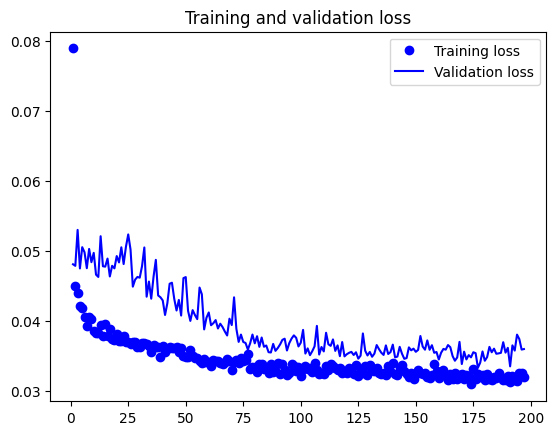

In [20]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

plot_training_loss(training_loss, validation_loss)

Now we can see how the model predicts the power consumption for the next hour. To do this, I plot the actual and predicted power consumption over time

1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/stepWARNING:tensorflow:6 out of the last 12 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x00000239F34B92D0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


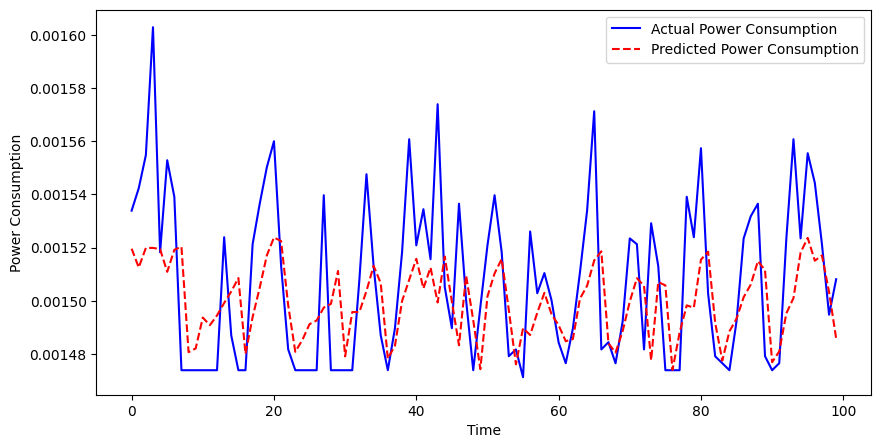

In [21]:
y_pred = model.predict(x_test)

# Reverse the scaling
y_test_rescaled = scaler.inverse_transform(np.column_stack([y_test] * len(features)))[:, 0]
y_pred_rescaled = scaler.inverse_transform(np.column_stack([y_pred.flatten()]*len(features)))[:, 0]

plot_power_time(y_test=y_test_rescaled, y_pred=y_pred_rescaled)

## Establishing a baseline

Since the model's prediction is not as meaningful without a reference, I want to establish a baseline. The simplest baseline for a short term prediction is that the value does not change at all. Therefore, I want a baseline that predicts the current power consumption to be the next hour's power consumption. To be consistent, I also want to use a neural network for the baseline. This has the big advantage that I can evaluate both models with the same functions and a comparison is easy.

Again, I start by preparing the data. I want to use the same input form as the LSTM network, so I can use the same input data. All I need to change is the expected output, this time it should be the current power consumption. So I shift the output values by one. After that, I split the data set again into training and validation sets.

In [11]:
# Prepare data
power_values = df[[target]].values

y_baseline = power_values[(sequence_lenght-1):] # shifting the output that the current power consumption matches the next

# Split data set
y_train_baseline, y_test_baseline = y_baseline[:train_size], y_baseline[train_size:-1]

# Define model as identity function
baseline_model = Sequential([
    Flatten(),
    Dense(1)
])

baseline_model.compile(optimizer="adam", loss='mse', metrics=["mae"])

baseline_history = baseline_model.fit(x_train, y_train_baseline,
                                      epochs=200, batch_size=16,
                                      validation_data=(x_test, y_test_baseline),
                                      callbacks=[stop_training],  verbose=1)


Epoch 1/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1703 - mae: 0.3228 - val_loss: 0.3607 - val_mae: 0.4852
Epoch 2/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1219 - mae: 0.2764 - val_loss: 0.2668 - val_mae: 0.4024
Epoch 3/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1016 - mae: 0.2537 - val_loss: 0.2344 - val_mae: 0.3729
Epoch 4/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0964 - mae: 0.2487 - val_loss: 0.2151 - val_mae: 0.3550
Epoch 5/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0904 - mae: 0.2411 - val_loss: 0.1891 - val_mae: 0.3305
Epoch 6/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0851 - mae: 0.2369 - val_loss: 0.1701 - val_mae: 0.3130
Epoch 7/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0825 - mae: 0.2360 - val_loss: 0.1522 - val_mae: 0.2955
Epoch 8/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0781 - mae: 0.2248 - val_loss: 0.1395 - val_mae: 0.2826
Epoch 9/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.073

Now I want to verify that the model has the desired behavior by plotting the power prediction again.

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


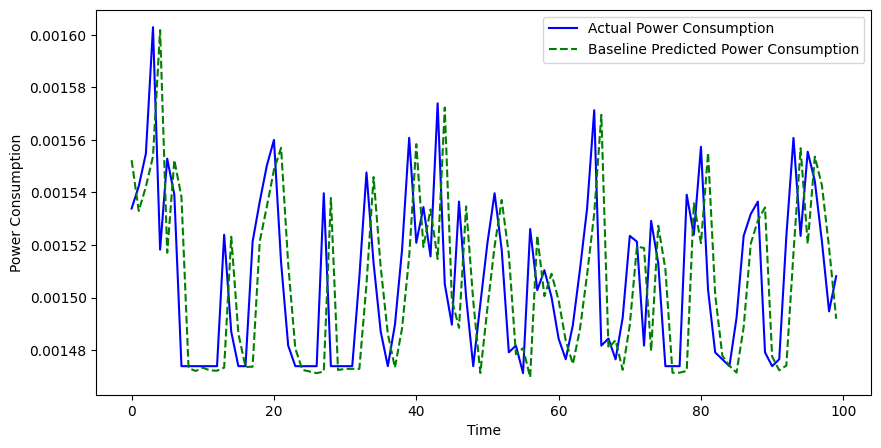

In [12]:
y_baseline_pred = baseline_model.predict(x_test)

y_test_rescaled = scaler.inverse_transform(np.column_stack([y_test] * len(features)))[:, 0]
y_baseline_pred_rescaled = scaler.inverse_transform(np.column_stack([y_baseline_pred.flatten()]*len(features)))[:, 0]

plot_power_time(y_test=y_test_rescaled,y_baseline_pred=y_baseline_pred_rescaled)

I want to finish Challenge 1 with a small evaluation. This evaluation calculates the Mean Absolute Error and the Root Mean Squared Error, so that the improvement of the LSTM model over the baseline can be determined in percent.

In [22]:
# Performance comparision

y_test_rescaled = scaler.inverse_transform(np.column_stack([y_test] * len(features)))[:, 0]
y_baseline_pred_rescaled = scaler.inverse_transform(np.column_stack([y_baseline_pred.flatten()]*len(features)))[:, 0]
y_pred_rescaled = scaler.inverse_transform(np.column_stack([y_pred.flatten()]*len(features)))[:, 0]

mae_lstm = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
rmse_lstm = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))

mae_baseline = mean_absolute_error(y_test_rescaled, y_baseline_pred_rescaled)
rmse_baseline = np.sqrt(mean_squared_error(y_test_rescaled, y_baseline_pred_rescaled))

print(f"LSTM Model: MAE = {mae_lstm:.4f}, RMSE = {rmse_lstm:.4f}")
print(f"Baseline Model: MAE = {mae_baseline:.4f}, RMSE = {rmse_baseline:.4f}")

mae_improvement = (mae_baseline - mae_lstm) / mae_baseline * 100
rmse_improvement = (rmse_baseline - rmse_lstm) / rmse_baseline * 100

print(f"MAE improvement: {mae_improvement:.2f} %")
print(f"RMSE improvement: {rmse_improvement:.2f} %")

LSTM Model: MAE = 0.0000, RMSE = 0.0000
Baseline Model: MAE = 0.0000, RMSE = 0.0000
MAE improvement: 15.63 %
RMSE improvement: 17.11 %


## Results

The evaluation results indicate that the LSTM model demonstrates superior performance in comparison to the baseline. The LSTM model demonstrates a substantial enhancement, achieving approximately 15% improvement across both metrics. This enhancement is comparable to a significant improvement, which would be approximately 20%. It is postulated that this enhancement can be realized by further optimization of features, network architecture, and hyperparameters. In the context of more extensive research, the utilization of tools such as "Weights and Biases" can facilitate parameter sweeps. Furthermore, statistically robust results are best achieved by training and evaluating multiple models. This approach facilitates the estimation of error metrics with standard error.

Another promising approach involves the application of additional methods, such as gradient boosting, to address this issue. This objective can be achieved by leveraging the capabilities of the XGBoost package.

However, it is important to note that limitations may arise from the small size of the data set and its correlation. The latter is a challenge that is difficult to surmount; however, the former can be addressed by augmenting the dataset with additional data. One potential approach involves generating synthetic data.

# Challenge 2
---
## Desciption
ESA wants to deploy the latest forecast model to the ISS so that ISS astronauts can also run the forecast
by themselves, without waiting for the forecast predictions from Earth. To do that, the forecast model
must be serialized and sent to the ISS. However, the machine on ISS only runs Java, while the forecast
model is in Python. What do you recommend? Please choose the BEST possible answer and justify
your choice.
## Solution
It is evident that options 1 and 2 are not viable solutions. The utilization of Pickle is not recommended due to its lack of language independence, and the employment of CSV is not viable as it is incapable of accommodating the complete set of necessary information. Protocol Buffers, while a promising alternative, would require a significant investment to implement.

For a Tensorflow.Keras model analogous to the one utilized for the task, the "SavedModel" format would be the optimal choice due to its optimization for machine learning models, comprehensive data representation, and the fact that it can be loaded using the Tensorflow Java extension.

In the event that a different machine learning model is employed, the "Open Neural Network Exchange" library can be utilized to transform the model into a universal format that is cross-platform compatible. 

Since I have no experience with cross-platform machine learning, I cannot verify any of these approaches and have not tested them. These answers are based solely on assumptions and research on the topic.


# Challenge 3
---
## Desciption
This graph shows the electric consumption over time of the Space mission. If we compute the
correlation between this year and the previous year, what do you think its value would be and why?

![electric consumption over time graph](graph.png "electric consumption over time graph")

## Solution

It is reasonable to hypothesize a value close to 1. The graph demonstrates a consistent increase in electric consumption over time, indicating a positive correlation between the two variables. The presence of strong seasonal variations, with periodic peaks and valleys, does not disrupt the overall upward trend. 

If the value were closer to 0, it would indicate a less pronounced trend, which is not the case. Conversely, a negative value would imply a decrease in electric consumption over time, which is not observed in the data. A value of 0 would indicate no correlation, suggesting a random distribution of the data with no presence of a clear pattern.
